In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import collections
import pathlib

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import os
import re
import shutil
import string



print(tf.__version__)

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

2.12.0


In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#nltk
import nltk

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for part-of-speech tagging
from nltk import pos_tag

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# BeautifulSoup libraray
from bs4 import BeautifulSoup 

import re # regex

#model_selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation
from sklearn.metrics import accuracy_score,roc_auc_score 
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

#preprocessing scikit
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
 
#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

#keras
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

#gensim w2v
#word2vec
from gensim.models import Word2Vec

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# from subprocess import check_output
# print(check_output(["ls", "../datasets/"]).decode("utf8"))

In [5]:
def read_train_data():
    data = pd.read_json('../datasets/dataset.json')
    mapping = {False: 0, True: 1}
    data.replace({'hasBadWords': mapping}, inplace=True)
    data.rename(columns={"hasBadWords": "labels"}, inplace=True)
    data.rename(columns={"text": "raw_text"}, inplace=True)
    data.drop(['violation'], axis=1, inplace=True)
    print('Data size %d' % len(data))
    print('Data headers %s' % data.columns.values)
    return data

# Preprocessing function

In [6]:
data = read_train_data()

Data size 86439
Data headers ['raw_text' 'labels']


In [7]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = word_tokens #" ".join(word_tokens)
    return cleaned_review

In [8]:
data['text'] = data.apply(lambda row: clean_text(row.raw_text), axis=1)

In [9]:
data.head()

,raw_text,labels,text
0,My Favorite Slut,0,"[favorite, slut]"
1,girlfriends sit on each other's faces with the...,0,"[girlfriend, sit, face, ass]"
2,bound beauty kisses her girlfriend,0,"[bound, beauty, kiss, girlfriend]"
3,MORGAN - Anytime - Nail Painting On The Slave'...,0,"[morgan, anytime, nail, painting, slave, face]"
4,TRANSGENDER COACHING (wmv) PART 1,0,"[transgender, coaching, wmv, part]"


In [10]:
data = data[['text', 'labels']]#, 'raw_text']] # columns reorder

In [11]:
data.head()

,text,labels
0,"[favorite, slut]",0
1,"[girlfriend, sit, face, ass]",0
2,"[bound, beauty, kiss, girlfriend]",0
3,"[morgan, anytime, nail, painting, slave, face]",0
4,"[transgender, coaching, wmv, part]",0


# Simple vectorzation

In [12]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [13]:
#words = counter_word(data.text)
words = Counter()

In [14]:
for text in data['text']:
    words.update(text)

In [15]:
len(words)

52659

In [16]:
words.most_common(10)

[('foot', 40360),
 ('fetish', 26751),
 ('clip', 19402),
 ('as', 13295),
 ('video', 13142),
 ('girl', 12521),
 ('big', 10888),
 ('domination', 10362),
 ('store', 9679),
 ('cum', 9484)]

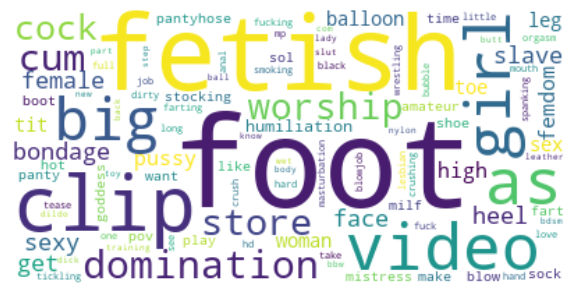

In [17]:
from wordcloud import *
word_freq = [i for i in words.most_common(100)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Create dictionary ordered by frequency

Start from 2, because of

* 0 - code filler
* 1 - unknown word

In [18]:
word_to_index = dict()
index_to_word = dict()

In [19]:
max_words = 10000

In [20]:
for i, word in enumerate(words.most_common(max_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

In [21]:
#word_to_index

In [22]:
#index_to_word

In [23]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 - unknown word
        # Unknown words doesn't include to output sequence
        if index != 1:
            seq.append(index)
    return seq

In [24]:
txt = data['text'][10]

In [25]:
seq = [word_to_index.get(word, 1) for word in txt]

In [26]:
print(txt)
print(seq)

['morgan', 'anytime', 'lick', 'sexy', 'mule', 'clean', 'shoe', 'worship', 'domination']
[1081, 2867, 169, 18, 1545, 402, 33, 12, 9]


In [27]:
index_to_word[9]

'domination'

In [28]:
data['sequences'] = data.apply(lambda row: text_to_sequence(row['text'], word_to_index), axis=1)
data = data[['text', 'sequences', 'labels']] # columns reorder

In [29]:
data.head()

,text,sequences,labels
0,"[favorite, slut]","[709, 89]",0
1,"[girlfriend, sit, face, ass]","[462, 425, 16, 868]",0
2,"[bound, beauty, kiss, girlfriend]","[135, 438, 331, 462]",0
3,"[morgan, anytime, nail, painting, slave, face]","[1081, 2867, 200, 2095, 15, 16]",0
4,"[transgender, coaching, wmv, part]","[2005, 124, 85]",0


# Make the bag of words

In [30]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

In [31]:
vactors = vectorize_sequences(data['sequences'], max_words)

# Word2Vec learn

In [32]:
import gensim.models

In [33]:
t = time()

# Creating model
cores = multiprocessing.cpu_count()

w2v_model = gensim.models.Word2Vec(data['text'],
                               min_count=1,
                               window=3,
                               sample=6e-5, 
                               alpha=0.03,
                               min_alpha=0.0007,
                               negative=20,)
                               #workers=cores-1)

# min_count=2 - how many times word in set

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.09 mins


In [34]:
w2v_model.build_vocab(data['text'], progress_per=1000)

In [35]:
t = time()

w2v_model.train(data['text'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.48 mins


In [36]:
w2v_model.wv['slut']

array([-1.5777873 ,  0.0955653 , -0.11120126, -0.43514183,  0.34534177,
        0.9558935 , -0.8373334 ,  0.9033173 , -0.7473246 ,  0.7204027 ,
       -0.82049304,  0.6098101 , -0.76265585,  0.11437129, -1.1652796 ,
       -0.66121125,  0.5405814 , -0.21270001,  0.7271348 ,  0.132518  ,
        1.2678565 ,  1.2161983 ,  0.65885985,  0.96572655,  0.9761747 ,
       -0.47487628,  0.9669104 ,  0.04296661, -0.6060566 , -0.0169639 ,
       -0.38032186,  0.6848404 , -1.1555619 , -0.51599735,  0.1845316 ,
        0.6320226 ,  0.6931581 , -0.14404707, -0.31879646,  0.41641888,
        1.1814036 ,  0.65092474, -0.16006508, -0.1588715 ,  1.958122  ,
        0.02780686,  0.8297488 ,  0.34752223,  0.58064234, -2.1911328 ,
       -0.2533787 , -0.13357952,  0.9172124 ,  1.8621312 ,  0.5619504 ,
        0.8953978 , -0.4914977 ,  0.32998514, -0.2680355 ,  0.05234768,
       -0.9573229 , -0.5110791 ,  0.18041179,  1.7746918 , -1.217698  ,
        0.47743696,  0.2761381 ,  1.2256862 ,  0.12907483, -1.26

In [39]:
w2v_model.wv.most_similar('slut')

[('submissive', 0.7390252351760864),
 ('whore', 0.7333680987358093),
 ('sissy', 0.6842961311340332),
 ('fucking', 0.6110881567001343),
 ('cocksucker', 0.6013455390930176),
 ('fuck', 0.5882770419120789),
 ('training', 0.5874873399734497),
 ('sex', 0.5773995518684387),
 ('cunt', 0.5667006969451904),
 ('strap', 0.5637659430503845)]

# Model saving

In [40]:
w2v_model.save('../models/word2vec-80k.model')

# Model loading

In [41]:
new_w2v_model = gensim.models.Word2Vec.load('../models/word2vec-80k.model')

In [42]:
new_w2v_model.wv.most_similar('slut')

[('submissive', 0.7390252351760864),
 ('whore', 0.7333680987358093),
 ('sissy', 0.6842961311340332),
 ('fucking', 0.6110881567001343),
 ('cocksucker', 0.6013455390930176),
 ('fuck', 0.5882770419120789),
 ('training', 0.5874873399734497),
 ('sex', 0.5773995518684387),
 ('cunt', 0.5667006969451904),
 ('strap', 0.5637659430503845)]

In [43]:
new_w2v_model.wv.similarity(w1="fuck", w2="sex")

0.64281046

In [44]:
data['labels'] = data['labels'].astype('category')
print('dimension: ', data.shape)
data.head()

dimension:  (86439, 3)


,text,sequences,labels
0,"[favorite, slut]","[709, 89]",0
1,"[girlfriend, sit, face, ass]","[462, 425, 16, 868]",0
2,"[bound, beauty, kiss, girlfriend]","[135, 438, 331, 462]",0
3,"[morgan, anytime, nail, painting, slave, face]","[1081, 2867, 200, 2095, 15, 16]",0
4,"[transgender, coaching, wmv, part]","[2005, 124, 85]",0


In [45]:
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['text']
y = data['labels']

In [58]:
test_size = 0.1
random_state = 1234

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y)

val_size = 0.1
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=random_state, stratify=y_train)

# Keras implementation